In [59]:
import os
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ntpath

sns.set()

In [2]:
# Testing if Tensorflow GPU is beeing used
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2022-03-06 12:40:02.887514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-06 12:40:03.023785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 12:40:03.066553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 12:40:03.066653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
#To specify the directory, so we can read and manipulate the DATA and cvs files
datadir = "./"
column_names = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = column_names)
#To see the first 5 lines of the created dataFrame
df.head()

center  \
0  /home/lucasmirachi/Desktop/IMG/center_2022_03_...   
1  /home/lucasmirachi/Desktop/IMG/center_2022_03_...   
2  /home/lucasmirachi/Desktop/IMG/center_2022_03_...   
3  /home/lucasmirachi/Desktop/IMG/center_2022_03_...   
4  /home/lucasmirachi/Desktop/IMG/center_2022_03_...   

                                                left  \
0  /home/lucasmirachi/Desktop/IMG/left_2022_03_03...   
1  /home/lucasmirachi/Desktop/IMG/left_2022_03_03...   
2  /home/lucasmirachi/Desktop/IMG/left_2022_03_03...   
3  /home/lucasmirachi/Desktop/IMG/left_2022_03_03...   
4  /home/lucasmirachi/Desktop/IMG/left_2022_03_03...   

                                               right  steering  throttle  \
0  /home/lucasmirachi/Desktop/IMG/right_2022_03_0...       0.0       0.0   
1  /home/lucasmirachi/Desktop/IMG/right_2022_03_0...       0.0       0.0   
2  /home/lucasmirachi/Desktop/IMG/right_2022_03_0...       0.0       0.0   
3  /home/lucasmirachi/Desktop/IMG/right_2022_03_0...       0.0       0.0   
4  /home/lucasmirachi/Desktop/IMG/right_2022_03_0...       0.0       0.0   

   reverse         speed  
0      0.0  5.357110e-06  
1      0.0  1.469713e-06  
2      0.0  6.011261e-06  
3      0.0  6.851298e-07  
4      0.0  1.071879e-05

In [4]:
#Because we don't want to show the image path itself, we'll cut it using the module ntpath
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [5]:
df['center'] = df['center'].apply(path_leaf)
df['left'] = df['left'].apply(path_leaf)
df['right'] = df['right'].apply(path_leaf)
df.head()

center                              left  \
0  center_2022_03_03_22_58_47_923.jpg  left_2022_03_03_22_58_47_923.jpg   
1  center_2022_03_03_22_58_47_994.jpg  left_2022_03_03_22_58_47_994.jpg   
2  center_2022_03_03_22_58_48_064.jpg  left_2022_03_03_22_58_48_064.jpg   
3  center_2022_03_03_22_58_48_135.jpg  left_2022_03_03_22_58_48_135.jpg   
4  center_2022_03_03_22_58_48_205.jpg  left_2022_03_03_22_58_48_205.jpg   

                               right  steering  throttle  reverse  \
0  right_2022_03_03_22_58_47_923.jpg       0.0       0.0      0.0   
1  right_2022_03_03_22_58_47_994.jpg       0.0       0.0      0.0   
2  right_2022_03_03_22_58_48_064.jpg       0.0       0.0      0.0   
3  right_2022_03_03_22_58_48_135.jpg       0.0       0.0      0.0   
4  right_2022_03_03_22_58_48_205.jpg       0.0       0.0      0.0   

          speed  
0  5.357110e-06  
1  1.469713e-06  
2  6.011261e-06  
3  6.851298e-07  
4  1.071879e-05

<BarContainer object of 25 artists>

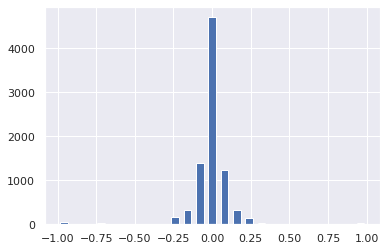

In [6]:
#In order to visualize the distribution, we'll now plot the histogram of steering angles for every set of images, so we can see the distribution and know which steering angles are more frequent in our recording
#To plot the distribution, we'll now plot the values in intervals
num_bins = 25
hist, bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(x = center, height = hist, width=0.05)

## Balancing the data

total data: 8467
removed: 6141
remaining: 2326


<BarContainer object of 25 artists>

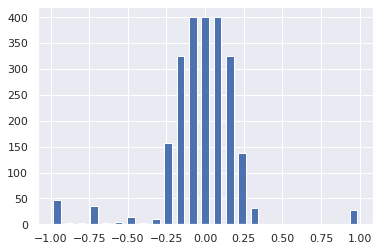

In [7]:
print('total data:', len(df))
#To flatten or samples and cut off the steering values which sum exceeds 400 and make it more uniform
#Edit: Because we were useing 200 as samples per bin before, our modeld couldnt drive straight very well, so we'll increase it from 200 to 400
samples_per_bin = 400
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(df['steering'])):
    #If the steering angle falls in between two bins, then it bellongs to the interval j
    if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
      list_.append(i)
      #Eventually, this list will contain all the steering numbers from a specific bin. Because our treshold in this project is max 200 steering numbers per bin, we need to reject the exceding ones, and, because the numbers are stored in an array in order, we need to shuffle first (if we just reject the last ones, we may be rejecting information from the end of our track which is bad for our model to predict how to drive properly on the end of the track)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
df.drop(df.index[remove_list], inplace=True)
print('remaining:', len(df))

hist, _ = np.histogram(df['steering'], (num_bins))
plt.bar(x = center, height = hist, width = 0.05)

## Training & Validation Split

In [8]:
#iloc (location i) allows to perform a selection to a row of data from our DataFrame based on a specified index. Example:
print(df.iloc[1])

center      center_2022_03_03_22_58_50_323.jpg
left          left_2022_03_03_22_58_50_323.jpg
right        right_2022_03_03_22_58_50_323.jpg
steering                             -0.205882
throttle                              0.134163
reverse                                    0.0
speed                                 0.056504
Name: 34, dtype: object


In [9]:
def load_img_steering(datadir,dataframe):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2] 
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

#                                           Track  +  /IMG/  = Track/IMG/        
image_paths, steerings = load_img_steering(datadir + '/IMG', df)

In [10]:
image_paths

array(['.//IMG/center_2022_03_03_22_58_50_253.jpg',
       './/IMG/center_2022_03_03_22_58_50_323.jpg',
       './/IMG/center_2022_03_03_22_58_50_398.jpg', ...,
       './/IMG/center_2022_03_03_23_08_46_775.jpg',
       './/IMG/center_2022_03_03_23_08_47_690.jpg',
       './/IMG/center_2022_03_03_23_08_48_034.jpg'], dtype='<U41')

In [11]:
#To split our image_paths and steering arrays into train and test 
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size=0.2)
#Checking their sizes (test size is 20% of the total and train is 80%)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1860
Validation Samples: 466


Text(0.5, 1.0, 'Validation set')

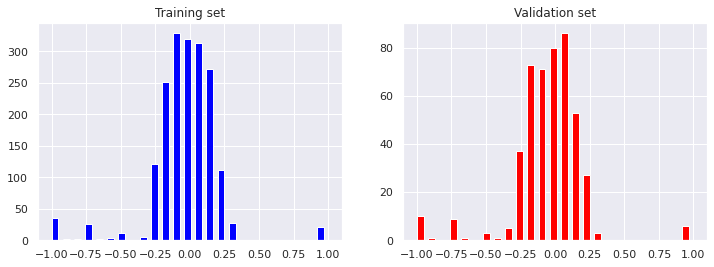

In [12]:
#To check if both sets have normally distributed samples
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

## Data Augmentation

In [17]:
#The library we're going to use in order to apply image augmentation techniques is the "imgaug" (IMG AUGmentation)
from imgaug import augmenters as iaa
import random

In [15]:
def zoom(image):
  #To apply Zoom of up to 30% to our images to our images (% of Zoom will be chosen randomly)
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

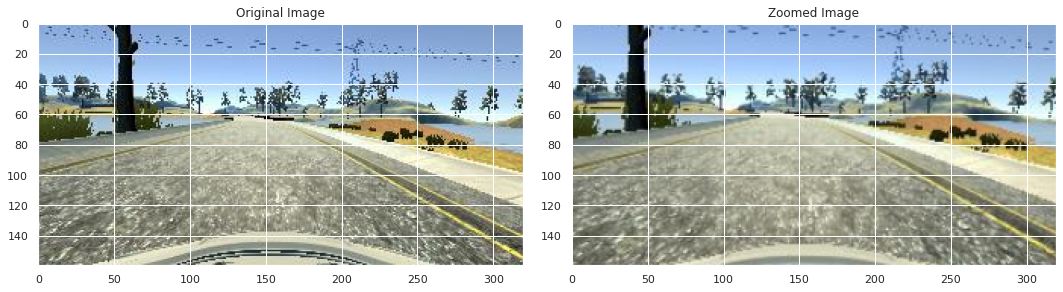

In [20]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
#To ensure that the figures will mantain formats and dont overlap
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [21]:
def pan(image):
  #This technique will translate our image 10%left and 10%right and 10%upperdown and 10%upwards (percentages chosen randomly)
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y" : (-0.1, 0.1) })
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

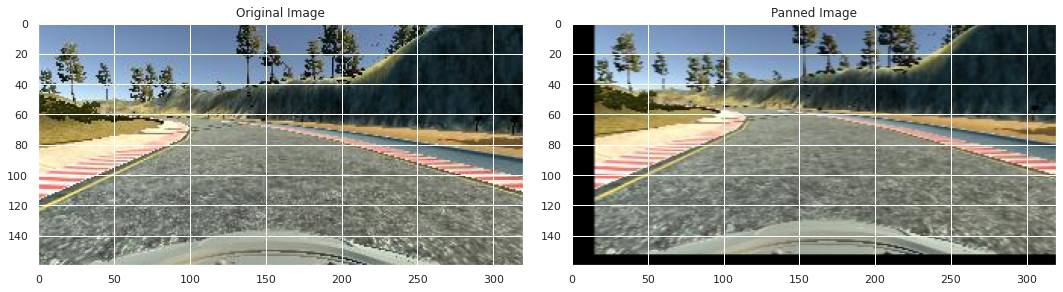

In [22]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
#To ensure that the figures will mantain formats and dont overlap
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [23]:
def img_random_brightness(image):
  #This function multiplies all the pixel intensities insede the image, thus any pixel intensity multiplied by a value less than 1 will become darker
  #Usually, this models works better with higher fractions of darker images
  brightness = iaa.Multiply(mul=(0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

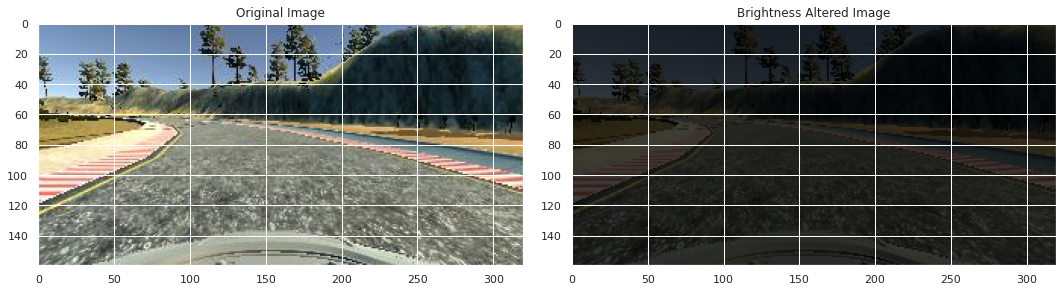

In [27]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
#To ensure that the figures will mantain formats and dont overlap
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [28]:
def img_random_flip(image, steering_angle):
  #Here we'll flip the image horizontaly (and also invert the steering angle so we won't mess up our data)
  image = cv2.flip(src=image, flipCode=1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.1941176')

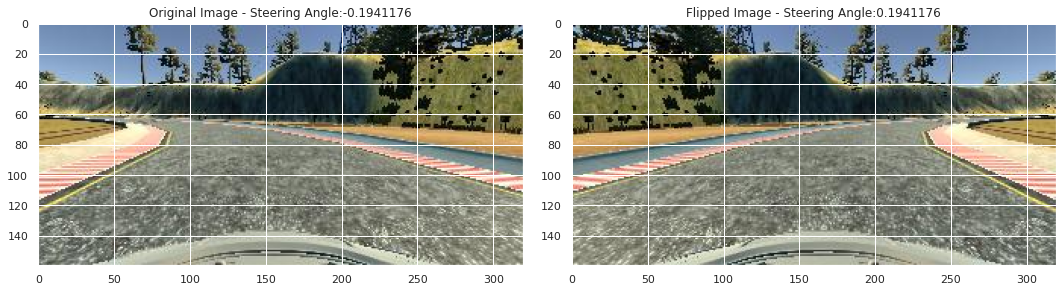

In [29]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
#To ensure that the figures will mantain formats and dont overlap
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [30]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  #For this project, we'll set the augmentation techniques to happen randomly 50% of the time
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

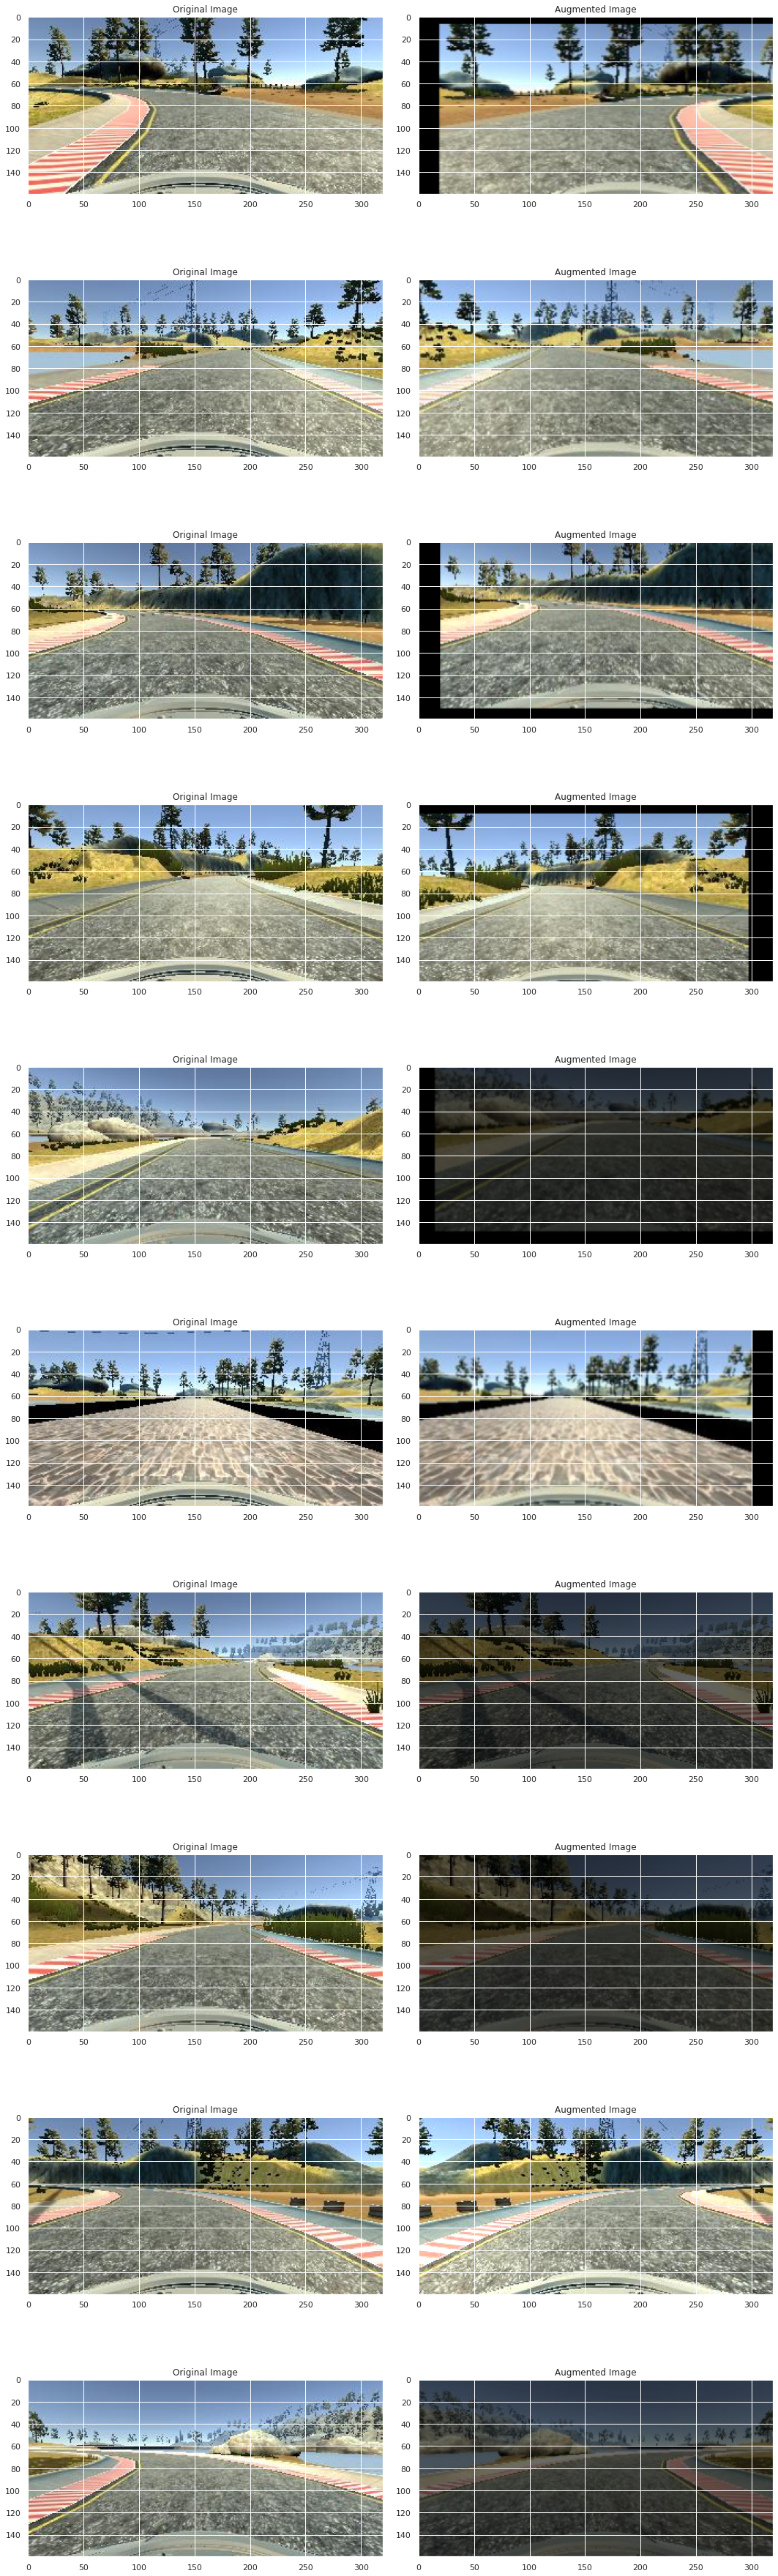

In [31]:
# To take a visual understanding of how the 4 augmentation techniquel will be apllyed to the dataset:
fig, axs = plt.subplots(nrows=10,ncols=2,figsize=(15,50))
#To make sure once again that nothing will be overlaped and everything will be formated:
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) -1)
  #The random generated number will be used as an index number in our array to get an randem image in our dataset each time
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [32]:
def img_preprocess(img):
  #To read the image paths we provided and store the actual image it contains:
  #img = mpimg.imread(img) -> Took this off because we already have this inside the batch generator function down bellow
  #We can see that some features present in the image are not relevant to our model (such as the paisage on the top of the track and the car's hood, on the bottom). These unecessary features can be cropped with the following code:
  img = img[60:135,:,:]
  #Because we're working with the NVidea Model, it is required to change our image color-space from RGB to YUV
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  #Applying 3x3-Kernel GaussianBlur to smooth the image and reduce noie
  img = cv2.GaussianBlur(img, (3,3), 0)
  #To resize the image and decrease its size, so we'll have a faster computation
  img = cv2.resize(src=img, dsize=(200,66))
  #Normalization, so black pixels will be 1 and white will be 0
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

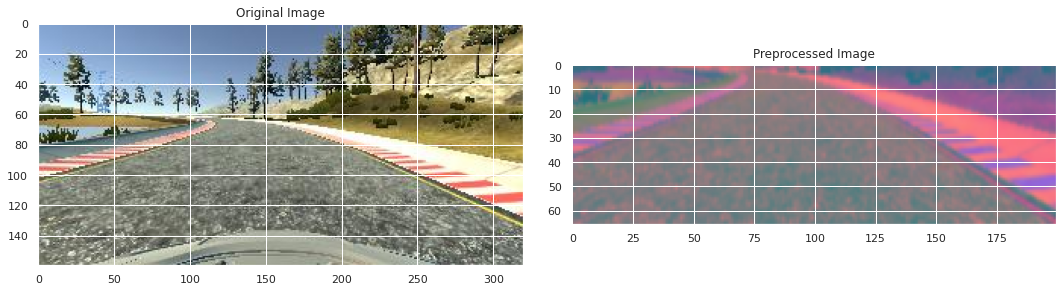

In [33]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

## Creating Image Generator

In [34]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image = image_paths[random_index], steering_angle=steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

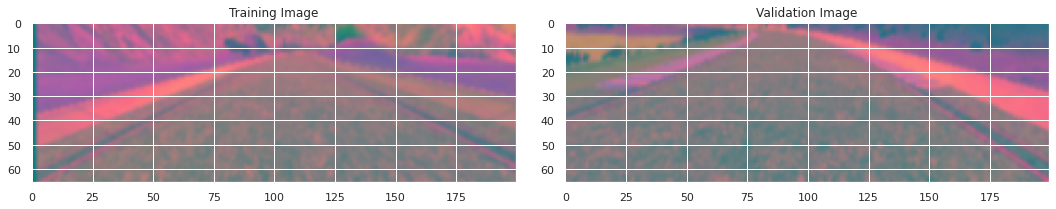

In [35]:
x_train_gen, y_train_gen = next(batch_generator(image_paths=X_train, steering_ang=y_train, batch_size=1, istraining=1))
#Since we're now using validation data, we dont want to aug them, so istraining=0
x_valid_gen, y_valid_gen = next(batch_generator(image_paths=X_valid, steering_ang=y_valid, batch_size=1, istraining=0))

#To plot the data to make sure everything is working as expected
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")

---
## Defining the NVIDIA MODEL
Because the goal of this model is to predict the steering angle based on the image, it is a regression type model and a popular model used for behavioural cloning is called the **Nvidia Model** (more information [here](https://drive.google.com/file/d/1g5OCEUGjSYAHu-wbq6muDk8fAyIpVRfG/view?usp=sharing)) which has proven to be effective for behavioural cloning and is also used on real life self driving cars!

The Nvidia Model's architecture is like:
<center><img src="https://miro.medium.com/max/2504/1*2Z_8DB1ybUmRaHUsyi6bSA.png" width="575" height="500"></center>

<center><a href='https://towardsdatascience.com/deep-learning-for-self-driving-cars-7f198ef4cfa2'>Source</a></center>



In [57]:
def nvidia_model():

  model = Sequential()
 
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  #model.add(Dropout(0.5))
 
 
  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))
 

  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(1))
 
  optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4)
  #Because we'll be working with a regression type example, the error metric is going to be the MSE (Mean Squared Error)
  model.compile(loss='mse', optimizer=optimizer)
 
  return model

In [58]:
model = nvidia_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_32 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_33 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_34 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_6 (Flatten)         (None, 1152)              0         
                                                                 
 dense_24 (Dense)            (None, 100)              

In [60]:
history = model.fit_generator(batch_generator(image_paths=X_train, steering_ang=y_train, batch_size=100, istraining=1),
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data= batch_generator(image_paths=X_valid, steering_ang=y_valid, batch_size=100, istraining=0),
                              validation_steps = 200,
                              verbose=1,
                              shuffle=1)

/tmp/ipykernel_18970/1660596110.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(image_paths=X_train, steering_ang=y_train, batch_size=100, istraining=1),


Epoch 1/10


2022-03-06 19:56:30.681537: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-06 19:56:32.299595: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-06 19:56:32.536736: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 52s 482ms/step - loss: 0.0622 - val_loss: 0.0620
Epoch 2/10
100/100 [==============================] - 30s 304ms/step - loss: 0.0539 - val_loss: 0.0493
Epoch 3/10
100/100 [==============================] - 36s 366ms/step - loss: 0.0503 - val_loss: 0.0435
Epoch 4/10
100/100 [==============================] - 36s 367ms/step - loss: 0.0460 - val_loss: 0.0386
Epoch 5/10
100/100 [==============================] - 29s 297ms/step - loss: 0.0442 - val_loss: 0.0297
Epoch 6/10
100/100 [==============================] - 32s 320ms/step - loss: 0.0381 - val_loss: 0.0274
Epoch 7/10
100/100 [==============================] - 31s 310ms/step - loss: 0.0347 - val_loss: 0.0271
Epoch 8/10
100/100 [==============================] - 31s 309ms/step - loss: 0.0360 - val_loss: 0.0208
Epoch 9/10
100/100 [==============================] - 37s 372ms/step - loss: 0.0366 - val_loss: 0.0327
Epoch 10/10
100/100 [==============================] - 30s 303ms/step - loss: 0.0338

Text(0.5, 0, 'Epoch')

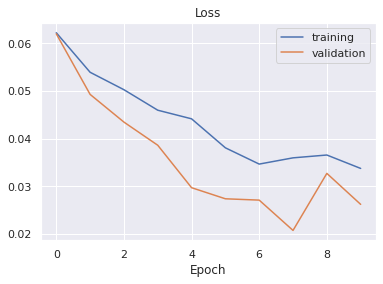

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [71]:
model.save('my_model.h5')